# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [5]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [6]:
# Define your network architecture here

from torch import nn
model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Linear(128,10))

# Create the network, define the criterion and optimizer
criterion = nn.CrossEntropyLoss()

from torch import optim

optimizer = optim.SGD(model.parameters(), lr = 0.03)

# Train the network here
epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0;
    for images,labels in trainloader:
        images = images.view(images.shape[0],-1)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0],-1)
                
                output = model(images)
                test_loss += criterion(output, labels)
                
                ss = output
                ps = torch.exp(ss) / torch.sum(torch.exp(ss), dim=1).view(-1,1)
                top_p,top_class = ps.topk(1)

                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.614..  Test Loss: 0.509..  Test Accuracy: 0.815
Epoch: 2/30..  Training Loss: 0.447..  Test Loss: 0.459..  Test Accuracy: 0.835
Epoch: 3/30..  Training Loss: 0.409..  Test Loss: 0.461..  Test Accuracy: 0.835
Epoch: 4/30..  Training Loss: 0.384..  Test Loss: 0.420..  Test Accuracy: 0.851
Epoch: 5/30..  Training Loss: 0.365..  Test Loss: 0.438..  Test Accuracy: 0.834
Epoch: 6/30..  Training Loss: 0.350..  Test Loss: 0.391..  Test Accuracy: 0.854
Epoch: 7/30..  Training Loss: 0.336..  Test Loss: 0.389..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.326..  Test Loss: 0.380..  Test Accuracy: 0.863
Epoch: 9/30..  Training Loss: 0.315..  Test Loss: 0.373..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.306..  Test Loss: 0.362..  Test Accuracy: 0.869
Epoch: 11/30..  Training Loss: 0.297..  Test Loss: 0.372..  Test Accuracy: 0.866
Epoch: 12/30..  Training Loss: 0.291..  Test Loss: 0.367..  Test Accuracy: 0.865
Epoch: 13/30..  Training Loss: 0.283.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

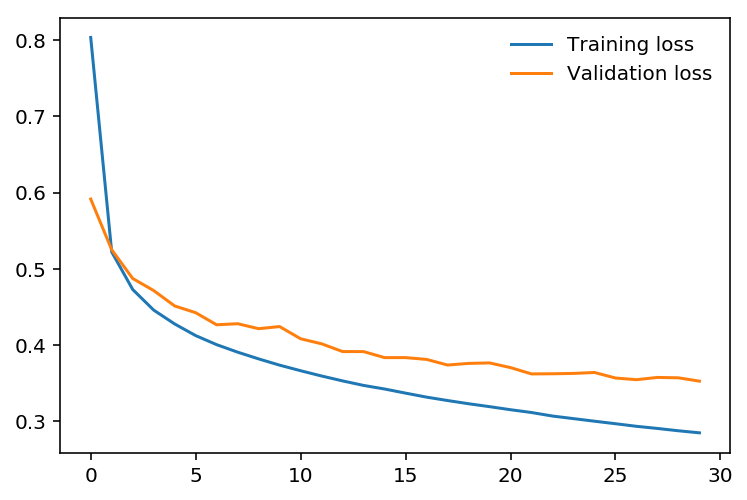

In [4]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)